# Primary Productivity Regression Analysis  
## Linear regression analysis of the interim and legacy product
> History | Updated Apr 2024  

## Objectives
Calculate the mean values of the interim VIIRS netPP product (netPP<sub>VIIRS</sub>) and legacy MODIS netPP product (netPP<sub>MODIS</sub>) within a user-specified region for each month from 2013-2022.  
* The result will be a 120-month (10-year) mean monthly timeseries of both netPP<sub>VIIRS</sub> and netPP<sub>MODIS</sub> within your area of interest.  

Use the two time series to run a linear regression for netPP<sub>VIIRS</sub> vs. netPP<sub>MODIS</sub>


> __Steps__:   
> * Download a timeseries of monthly netPP<sub>VIIRS</sub> values and of netPP<sub>MODIS</sub> values from an ERDDAP server.  
> * Mask both timeseries so that only data within a shapefile is retained.  
> * Calculate the netPP<sub>VIIRS</sub> vs. netPP<sub>MODIS</sub>, including slopes, y-intercepts, and R<sup>2</sup> values. 
> * Visualized the regression and save the data.

## Resource requirements
-   Jupyter Notebook
-   Python 3 with the modules included within the "Import packages" section below.  
-   A shapefile with your area of interest
    * If you don't have shapefile, we will include some workarounds in the notebook.
    * The shapefiles for some standard marine provinces are also included::
        * __Longhurst Marine Provinces__: Available online (https://www.marineregions.org/downloads.php) and within the shapes folder associated with this repository.
        * __Marine Ecoregions Of the World (MEOW)__: Available online https://geospatial.tnc.org/datasets/ed2be4cf8b7a451f84fd093c2e7660e3_0/about and within the shapes folder associated with this repository
-   An Internet connection



## Satellite Datasets:  

__Legacy MODIS Aqua-based netPP, Global, 9km, 2013-2023__    
http://localhost:8080/erddap/griddap/netpp_modis_monthly_9km_2013_2022.graph     

__Interim VIIRS SNPP-based netPP, Global, 9km__  
http://localhost:8080/erddap/griddap/netpp_snpp_monthly_9km_2013_2022.graph   

Those datasets will be used in this notebook to generate a timeseries of monthly mean values of &psi;<sup>netPP</sup>. We will access the data using the xr_open_ds() function below. The function requires:  
* the url of the ERDDAP server being use, in this case "http://localhost:8080/"
* the ID of the dataset, in this case "netpp_modis_monthly_9km_2013_2022" for netPP<sub>MODIS</sub>and netpp_snpp_monthly_9km_2013_2022 for netPP<sub>VIIRS</sub>.

Let's put those items into separate variables. 

In [1]:
# set the url of the ERDDAP server
erddap_url = "http://localhost:8080"

# set the dataset ID
modis_id = 'netpp_modis_monthly_9km_2013_2022'
viirs_id = 'netpp_snpp_monthly_9km_2013_2022'

## Shapfiles

__Longhurst Marine Provinces__  
The dataset represents the division of the world oceans into provinces as defined by Longhurst (1995; 1998; 2006). This division has been based on the prevailing role of physical forcing as a regulator of phytoplankton distribution. The Longhurst Marine Provinces dataset is available online (https://www.marineregions.org/downloads.php) and within the shapes folder associated with this repository.  

<img src="longhurst.png"></img>

__For our example we will use the shapefile for the  "California Upwelling Coastal Province" (ProvCode: CCAL) within the Longhurst Marine Provinces classification__. 

## Resource requirements
-   Jupyter Notebook  
-   Python 3 with the modules included within the "Import packages" section below.   
-   A shapefile with your area of interest  
    * If you don't have shapefile, we will include some workarounds in the notebook.  
-   An Internet connection.  

## Import packages

In [2]:
import matplotlib.pyplot as plt
import xarray as xr
import geopandas
import regionmask
import pandas as pd
import warnings
import os
import seaborn as sns
from sklearn.metrics import r2_score
import numpy as np
warnings.filterwarnings('ignore')

## Create a few useful functions
### Function to make an Xarray dataset connection to an ERDDAP dataset

In [3]:
def xr_open_ds(e_id, e_source='https://coastwatch.pfeg.noaa.gov'):
    """Open a remote ERDDAP dataset.

    Args:
        e_id (str): ERDDAP dataset ID.
        e_source (str, optional): URL to ERDDAP server. Defaults to 'https://coastwatch.pfeg.noaa.gov/'.

    Returns:
        array: Xarray dataset object
    """
    erddap_url = '/'.join([e_source,
                           'erddap',
                           'griddap',
                           e_id
                           ])

    print(erddap_url)
    return xr.open_dataset(erddap_url)

### Function to spatially subset an Xarray dataset using latitude and longitude

In [4]:
def subset_ds(full_ds, var_name, bnds_dic):
    """Make a spatial subset a satellite dataset.

    Args:
        full_ds (array): 2D or 3D array with lat and lon coordinate variables
        var_name (str): Name of variable to subset.
        bnds_dic (dic): Dictionary holding lat and lon max and min values

    Returns:
        array: Xarray dataset object
    """
    # correct for reversed latitude order on a dataset
    if full_ds.latitude[0] > full_ds.latitude[-1]:
        lt_first = bnds_dic['lat_max']
        lt_last = bnds_dic['lat_min']
    else:
        lt_first = bnds_dic['lat_min']
        lt_last = bnds_dic['lat_max']
    
    # subset the dataset
    return full_ds[var_name].sel(latitude=slice(lt_first, 
                                                lt_last),
                                 longitude=slice(bnds_dic['lon_min'],
                                                 bnds_dic['lon_max'])
                                )

## Load the Longhurst Provinces shape files into a geopandas dataframe
For our example we will use the shapefile for the  "California Upwelling Coastal Province" (ProvCode: CCAL) within the Longhurst Marine Provinces classification. 
* In this step we will also isolate the California Upwelling Coastal Province. Uncomment  print(shapefiles[40:45]) to see where the shapefile is in the dataframe.

In [5]:
# create path to shapefile dataset
shape_path = os.path.join('..',
                          '..',
                          'shapes',
                          'longhurst',
                          'Longhurst_world_v4_2010.shp'
                          )

# create a dataframe
shapefiles = geopandas.read_file(shape_path)

# uncomment net line to see the California Upwelling Coastal Province entry
# print(shapefiles[40:45])

ProvCode = "CCAL"
coastal_CA = shapefiles.loc[shapefiles["ProvCode"] == ProvCode]
coastal_CA

,ProvCode,ProvDescr,geometry
43,CCAL,Coastal - California Upwelling Coastal Province,"MULTIPOLYGON (((-110.50000 24.50000, -110.5000..."


## Create the regional mask for the California Upwelling Coastal Province
Display the region after creating it. 

<GeoAxesSubplot:>

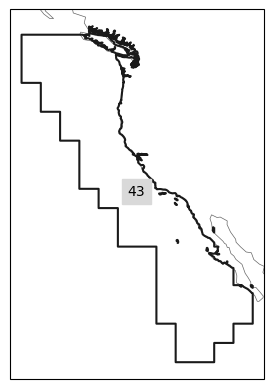

In [6]:
region = regionmask.from_geopandas(coastal_CA)
region.plot()

## Find the coordinates of the bounding box
* The bounding box is the smallest rectangle that will completely enclose the province. 
* We will use the bounding box coordinates to subset the satellite data 

In [7]:
gs_bnds = coastal_CA.bounds
gs_bnds

,minx,miny,maxx,maxy
43,-134.5,16.5,-110.5,51.383431


### To make it easier to use the subset_ds() function without a shapefile, put the bounding box coordinates in a Python dictionary.

In [8]:
geo_bnds = {}
geo_bnds['lon_min'] = gs_bnds.minx.item()
geo_bnds['lon_max'] = gs_bnds.maxx.item()
geo_bnds['lat_min'] = gs_bnds.miny.item()
geo_bnds['lat_max'] = gs_bnds.maxy.item()


## Open the MODIS netPP dataset into a xarray dataset object
Pass the dataset ID and the ERDDAP server location to the xr_open_ds() function.  
* Check the document string for the xr_open_ds() function for more information. 
* Just a reminder that we set the modis_id and erddap_url variable above.
* The ERDDAP dataset ID is "netpp_psi_snpp_modis"

In [9]:

ds_modis = xr_open_ds(modis_id,
                e_source=erddap_url)

ds_modis

ds_viirs = xr_open_ds(viirs_id,
                e_source=erddap_url)

ds_viirs

http://localhost:8080/erddap/griddap/netpp_modis_monthly_9km_2013_2022
http://localhost:8080/erddap/griddap/netpp_snpp_monthly_9km_2013_2022


<xarray.Dataset>
Dimensions:       (time: 120, latitude: 2160, longitude: 4320)
Coordinates:
  * time          (time) datetime64[ns] 2013-01-16T08:00:00 ... 2022-12-16T08...
  * latitude      (latitude) float64 89.96 89.88 89.79 ... -89.79 -89.88 -89.96
  * longitude     (longitude) float64 -180.0 -179.9 -179.8 ... 179.8 179.9 180.0
Data variables:
    productivity  (time, latitude, longitude) float32 ...
Attributes: (12/45)
    acknowledgement:           This project was supported by the NOAA Office ...
    cdm_data_type:             Grid
    contributor:               Dale Robinson, Jesse Espinoza, Isaac Schroeder
    contributor_role:          project management, development, production code
    Conventions:               CF-1.6, COARDS, ACDD-1.3
    creator_email:             erd.data@noaa.gov
    ...                        ...
    summary:                   Monthly means of net primary productivity and ...
    time_coverage_end:         2022-12-16T08:00:00Z
    time_coverage_resolution:  P1M
    time_coverage_start:       2013-01-16T08:00:00Z
    title:                     Primary Productivity, VIIRS SNPP, 9Km, Monthly...
    Westernmost_Easting:       -179.9583

### Note that the Data variable (above output) is named "productivity".  
* We will need that name when using the subset_ds() function.
* Let's put the Data variable name into a variable.    

In [10]:
# Set erddap_var with data variable name
erddap_var = 'productivity'

## Subset the satellite data
* Use the bounding box coordinates for the latitude and longitude slices

__The result will be datasets that are:__  
* Spatially subsetted to the dimensions of the bounding box that contains all 120 months of the ten-year period between 2013-2022

In [11]:
subsetted_modis_ds = subset_ds(ds_modis, 'productivity', geo_bnds)

subsetted_viirs_ds = subset_ds(ds_viirs, 'productivity', geo_bnds)


## Determine the approximate download size
Before downloading the data, it is good to estimate how big your data request to ERDDAP will be. 
* The data still has not been downloaded. That will happen later when an operation that needs the data is initiated. 

Depending on the installation, ERDDAP has maximum single download limit of 2 Gigabytes.  
* That seems large but with satellite dataset large data volume add up fast.

The calculation for data download size estimate is below. 
* If the download size is nearing the single download limit, try splitting your download request into 2 or several separate requests and concatenate the data from the separate request.  

#### The request in this example is around 85 MB, well within the single download limit  

In [12]:

pixel_lon_axis = subsetted_viirs_ds.longitude.shape[0]
pixel_lon_axis = subsetted_viirs_ds.latitude.shape[0]

float_memory_size = 4
no_of_timesteps = 120

download_size = (pixel_lon_axis
                 * pixel_lon_axis
                 * float_memory_size 
                 * no_of_timesteps)

print("download_size", int(download_size)/1000000, 'Mb')

wa_flag = False


download_size 84.26928 Mb


## Create a mask and apply it to the data
__The result will be datasets that are:__  
* Masked to retain only the data within the shapefile. 

In [13]:

# Create the mask
mask = region.mask(subsetted_modis_ds.longitude, subsetted_modis_ds.latitude)

# Apply mask the the satellite data
modis_ds = subsetted_modis_ds.where(mask == region.numbers[0])

viirs_ds = subsetted_viirs_ds.where(mask == region.numbers[0])


## Workaround if you do not have a shapefile

If you don't have a shapefile, you can instead select a rectangular area define by a latitude and a longitude range that encompasses your area of interest.  

#### Please see [Appendix B: Steps for use without a shapfile](#no_shapefile) below.


## Calculate the monthly mean for each month to create a timeseries.
The results are two 120-month (10-year) timeseries of global month mean netPP from 2012-2022: one for netPP<sub>MODIS</sub> and one for netPP<sub>VIIRS</sub>.  
* Merge the two timeseries into a single pandas dataframe.  
* Plot the two timeseries on the same graph.
* Uncomment the last two lines to save the graph and dataframe.

#### For our example:
* netPP<sub>VIIRS</sub> and netPP<sub>MODIS</sub> values are very similar in terms of seasonal pattern and magnitude.

                 time   modis_psi   viirs_psi
0 2013-01-16 08:00:00  489.595215  492.152954
1 2013-02-16 08:00:00  550.395203  562.066772


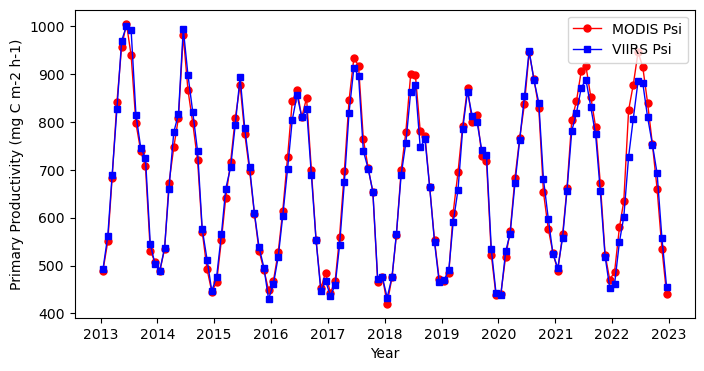

In [14]:
# generate the timeseries
modis_mean = modis_ds.mean(dim=['latitude', 'longitude'])
viirs_mean = viirs_ds.mean(dim=['latitude', 'longitude'])

# Merge the two timeseries into a single df
merged_df = pd.DataFrame({'time': modis_mean.time,
                          'modis_psi': modis_mean,
                          'viirs_psi': viirs_mean
                          }) 

print(merged_df.head(2))

# plot the results 
plt.figure(figsize = (8, 4)) 
# Plot the SeaWiFS data
plt.plot_date(merged_df.time, merged_df.modis_psi, 
              'o', markersize=5, 
              label='MODIS Psi', c='red', 
              linestyle='-', linewidth=1) 

# Add MODIS data
plt.plot_date(merged_df.time, merged_df.viirs_psi,  
              's', markersize=5, 
              label='VIIRS Psi', c='blue', 
              linestyle='-', linewidth=1) 

#plt.ylim([200, 2000])  # adjust this range to fit our area
plt.ylabel('Primary Productivity (mg C m-2 h-1)') 
plt.xlabel('Year')
plt.legend()

# uncomment the next two lines to save the figure and the dataframe
# merged_df.to_csv('my_psi_timeseries.csv', index=False)
# plt.savefig('my_psi_timeseries.png')


## Generate the linear regression
* First, remove any rows with no data
* Generate the regression with plot
* Calculate the slope, intercept, and R<sup>2</sup>  

#### For our example using the shape file (workaround data will be different):
* The slope (0.97) shows an almost one-to-one correspondence between netPP<sub>VIIRS</sub> and netPP<sub>MODIS</sub>
* The regression line explains 98% for the variability (R<sup>2</sup>=0.98)

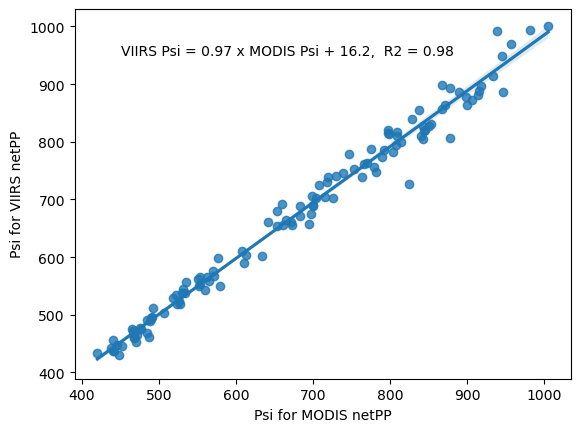

In [15]:
# Regression packages typically do not like nan's. Delete rows with nan
clean_merged_df = merged_df.dropna()

# Generate the regression plot
sns.regplot(x='modis_psi', y='viirs_psi', data=clean_merged_df)

# Calculate the slope and intercept
slope, intercept = np.polyfit(clean_merged_df["modis_psi"], clean_merged_df["viirs_psi"], 1)

# Calculate R2
r2 = r2_score(clean_merged_df["modis_psi"], clean_merged_df["viirs_psi"])

# uncomment use the next two lines to set axes ranges
# ax.set_xlim([400,1000])
# ax.set_ylim([400,1000])

plt.ylabel('Psi for VIIRS netPP') 
plt.xlabel('Psi for MODIS netPP')

# set the annotation position
y_anno_position = (clean_merged_df["viirs_psi"].max()* 0.95)
x_anno_position = (clean_merged_df["viirs_psi"].min()* 1.05)

# Annotate the plot
plt.annotate(f"VIIRS Psi = {slope:.2f} x MODIS Psi + {intercept:.1f},  R2 = {r2:.2f}", 
             xy=(x_anno_position, y_anno_position), 
             # xytext=(30, 5), 
             fontsize=10, 
             color="black", 
             ha="left")

show_plot = plt.show
# To save your data, uncomment the next line
# clean_merged_df.to_csv("virtual_buoy_example.csv", index=False)

## Appendix A: Visualize the unmasked and masked data on a map
The maps shows the full coverage of the bounding box and the masked area set by the shapefile fo CCAL.

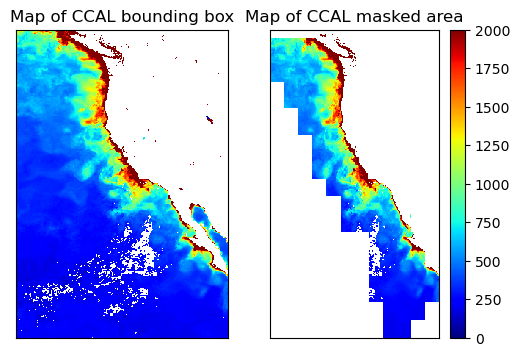

In [16]:
if wa_flag:
    plot_ds = viirs_ds
else:
    plot_ds = subsetted_viirs_ds

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 4))

ax1.set_title('Map of CCAL bounding box')
ax1.set_yticks([])
ax1.set_xticks([])

ax1.pcolormesh(plot_ds[7].reindex(latitude=list(reversed(plot_ds.latitude))),
                             vmin=0, vmax=2000,
                             cmap='jet')

ax2.set_title('Map of CCAL masked area')
ax2.set_yticks([])
ax2.set_xticks([])

pc = ax2.pcolormesh(viirs_ds[7].reindex(latitude=list(reversed(viirs_ds.latitude))),
                             vmin=0, vmax=2000,
                             cmap='jet')
fig.colorbar(pc)

## Appendix B: Steps for use without a shapfile
<a id='no_shapefile'></a>
### __Do not run this code if you have used a shapefile above!__
Use this method in place of cells tagged "Shapefile method".  

If you don't have a shapefile, you can just select a rectangular area that encompasses your area of interest. The area is define by a the maximum and minimum values of a latitude and a longitude range.   

__Steps__  
1. Load the geo_bnds dictionary with the minimum and maximum values for latitude and longitude the area of interest. 
* An area off the Oregon coast is used the example below:
    * Latitude range: 42.0&deg; to 46.0&deg; N  
    * Longitude range: -128.0&deg; to -124&deg; E
2. Proceed through the data download and subsetting steps as listed below:
* Note that the masking steps have been omitted.
* The returns from subset_ds() for MODIS netPP and VIIRS netPP are labeled modis_ds and viirs_ds, respectively

In [ ]:
geo_bnds = {}
geo_bnds['lon_min'] = -128.
geo_bnds['lon_max'] = -123.
geo_bnds['lat_min'] = 42.
geo_bnds['lat_max'] = 52.

# Add this code 
modis_ds = subset_ds(ds_modis, 'productivity', geo_bnds)
viirs_ds = subset_ds(ds_viirs, 'productivity', geo_bnds)

# set workaround flag
wa_flag = True

# Omit create the mask
# mask = region.mask(subsetted_modis_ds.longitude, subsetted_modis_ds.latitude)

# Omit apply mask the the satellite data
# modis_ds = subsetted_modis_ds.where(mask == region.numbers[0])
# viirs_ds = subsetted_viirs_ds.where(mask == region.numbers[0])

